In [2]:

%load_ext autoreload
%autoreload 2

import torch 
import numpy as np 
from dirichlet import * 
import torch
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri 

In [3]:
input = torch.tensor([[1,2,3],[3,4,6]])

In [4]:
import pyro.distributions as dist 
from pyro.contrib.forecast import eval_crps 

In [5]:
## by Pyro
input = torch.tensor(
    [[2.5335, 1.0041, 0.7144],
    [1.6092, 0.8942, 0.5548],
    [1.2650, 0.8000, 0.5933],
    [1.0805, 0.7738, 0.6637],
    [0.9782, 0.7739, 0.7240],
    [0.9198, 0.7838, 0.7656],
    [0.8854, 0.7958, 0.7913]]
)
print(input.shape)

drichilet = dist.Dirichlet(concentration=input)

target = torch.tensor(
    [[0.6655, 0.1367, 0.1978],
    [0.7197, 0.0738, 0.2065],
    [0.7093, 0.0834, 0.2073],
    [0.7244, 0.0801, 0.1955],
    [0.7356, 0.0760, 0.1884],
    [0.7345, 0.0790, 0.1865],
    [0.7429, 0.0701, 0.1870]]
)

value = 1e-08

target += value
print(target.shape)

drichilet.log_prob(target)

torch.Size([7, 3])
torch.Size([7, 3])


tensor([1.3975, 1.0940, 0.9886, 0.9475, 0.8947, 0.8240, 0.7980])

In [6]:
loss = -40 
log_likelihood = 40 
pdf = np.exp(log_likelihood)
print(pdf)

2.3538526683702e+17


In [7]:
## by Pyro
input = torch.tensor(
    [[2.5335, 1.0041, 0.7144],
    [1.6092, 0.8942, 0.5548],
    [1.2650, 0.8000, 0.5933],
    [1.0805, 0.7738, 0.6637],
    [0.9782, 0.7739, 0.7240],
    [0.9198, 0.7838, 0.7656],
    [0.8854, 0.7958, 0.7913]]
)


target = torch.tensor(
    [[0.6655, 0.1367, 0.1978],
    [0.7197, 0.0738, 0.2065],
    [0.7093, 0.0834, 0.2073],
    [0.7244, 0.0801, 0.1955],
    [0.7356, 0.0760, 0.1884],
    [0.7345, 0.0790, 0.1865],
    [0.7429, 0.0701, 0.1870]]
)



drichilet = dist.Dirichlet(concentration=target)


value = 1e-08

target += value
print(target.shape)

drichilet.log_prob(target)

torch.Size([7, 3])


tensor([-0.6118, -0.5378, -0.5531, -0.5392, -0.5271, -0.5302, -0.5164])

In [10]:
## by Pyro
input = torch.tensor(
    [[2.5335, 1.0041, 0.7144],
    [1.6092, 0.8942, 0.5548],]
)

drichilet = dist.Dirichlet(concentration=input)

target = torch.tensor(
    [[0.5,0.2, 0.3],
    [1.0, 0., 0.]]
)

value = 1e-08

target += value
print(target)

drichilet.log_prob(target)

tensor([[5.0000e-01, 2.0000e-01, 3.0000e-01],
        [1.0000e+00, 1.0000e-08, 1.0000e-08]])


tensor([ 0.8417, 10.4662])

In [11]:
drichilet_2 = Dirichlet(concentration=input)
target = torch.tensor(
    [[0.5,0.2, 0.3],[1.0, 0., 0.]]
)

drichilet_2.log_prob(target, value)

tensor([ 0.8417, 10.4662])

In [12]:
input = torch.tensor(
    [0.5,0.2, 0.3]
)
inference_drichilet = dist.Dirichlet(concentration=input)
val_target_tensor = torch.tensor(
    [0.5,0.2, 0.3]
)
print(type(inference_drichilet))

<class 'pyro.distributions.torch.Dirichlet'>


In [ ]:
#eval_crps -

## step 1: geenrate n_samples of the target from the empirical distrbution, (parameterised by the output)
## step 2: compute the divergence between two distributions (1 == empircal ; 2 = observed values (cdf = step fucniton))

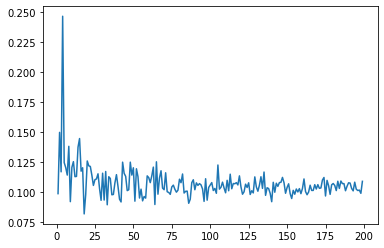

In [13]:
crps = []
n_samples = 200
for i in range(1,n_samples):
    samples = inference_drichilet.sample([i])
    crps.append(eval_crps(samples, val_target_tensor))
    
plt.figure()
plt.plot(
    list(range(1,n_samples)),
    crps
)
plt.show()

#samples

In [56]:
torch.sum(samples, dim = -1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

In [57]:
eval_crps(samples, val_target_tensor)

0.11650083214044571

In [ ]:
eval_crps()

In [ ]:
distributions = Dirichlet(concentration=input)
distributions.concentration

In [ ]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

In [ ]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

In [ ]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

In [ ]:
a = torch.tensor([0.9036, 0.9208, 0.9173])
b = torch.tensor([0.7231, 0.1062, 0.1707]) 

diff = a-b 

print(diff)

print(torch.norm(a-b,))
print(torch.norm(diff,))

In [ ]:
np.sqrt(0.1805**2 + 0.8146**2 + 0.7466**2)

In [ ]:
import matplotlib.pyplot as plt 
plt.figure() 
plt.plot([1,2,3], [0,1,2], 'rs', )
plt.plot([1,2,3,4], [0,1,2,3], 'rs', )

plt.figure() 
plt.plot([1,2,3], [0,1,2], 'rs', )
plt.plot([1,2,3,4], [0,1,2,3], 'rs', )



plt.figure() 
plt.plot(1, 2,'rs')

In [ ]:
list(range(0+1))

In [ ]:
output = [0.8077, 0.7874, 0.7990]
target = torch.tensor(
    [0.7231, 0.1062, 0.1707]
)

In [ ]:
output =  torch.tensor(
    
)
print(output)

In [ ]:
distribution = Dirichlet(output)
distribution.rsample()

In [ ]:
distribution.log_prob(target)

In [ ]:
distribution.sample_n(4)

In [ ]:
import math

def lbeta(alpha):
    return sum(math.lgamma(a) for a in alpha) - math.lgamma(sum(alpha))

def ldirichlet_pdf(alpha, theta):
    kernel = sum((a - 1) * math.log(t) for a, t in zip(alpha, theta))
    return kernel - lbeta(alpha)


In [ ]:
ldirichlet_pdf(output, target)

In [ ]:
m = torch.nn.Softmax(dim=1)  
input = torch.randn(2, 3) 
print(input)
print()
output = m(input) 
print(output)
print()
output_exp = torch.exp(output)
print(output_exp)

In [ ]:
draw_pdf_contours(Dirichlet(output_exp[0]))

In [ ]:
torch.clip(torch.tensor([100,200,1]), min = None, max = 100)

In [ ]:
1879%4

In [ ]:
1879//4

In [ ]:
469 * 4 

In [ ]:
468*4 

In [ ]:
469*4